In [59]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [60]:
NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X, y = make_blobs(n_samples=1000,
                  centers=NUM_CLASS,
                  n_features=NUM_FEATURES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

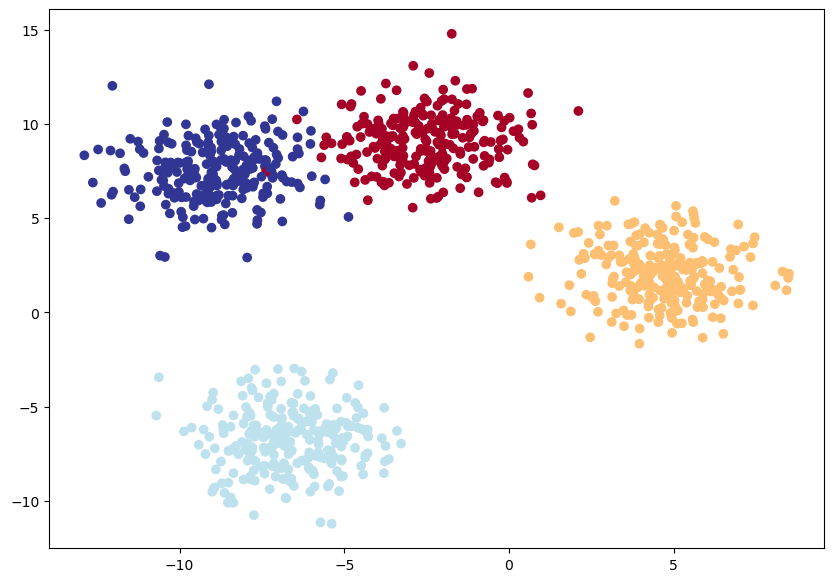

In [62]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [63]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [64]:
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [71]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_unit):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=n_outputs)
        )

    def forward(self, x):
        return self.net(x)

model = NeuralNetwork(X_train.shape[1], 4, 8).to(device)
model

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [73]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1500

for epoch in range(epochs):
    model.train()
    y_train_logits = model(X_train)
    y_train_loss = criterion(y_train_logits, y_train)
    y_train_preds = torch.softmax(y_train_logits, dim=1).argmax(dim=1)
    y_train_accuracy = (y_train_preds == y_train).float().mean()
    optimizer.zero_grad()
    y_train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_loss = criterion(y_test_logits, y_test)
        y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        y_test_accuracy = (y_test_preds == y_test).float().mean()
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} || Training Loss: {y_train_loss} || Training Accuracy: {y_train_accuracy} || Testing Loss: {y_test_loss} || Testing Accuracy: {y_test_accuracy}")

Epoch: 0 || Training Loss: 1.1588265895843506 || Training Accuracy: 0.4037500023841858 || Testing Loss: 1.1548902988433838 || Testing Accuracy: 0.35499998927116394
Epoch: 100 || Training Loss: 1.0905617475509644 || Training Accuracy: 0.5087500214576721 || Testing Loss: 1.0967098474502563 || Testing Accuracy: 0.4699999988079071
Epoch: 200 || Training Loss: 1.0246703624725342 || Training Accuracy: 0.6775000095367432 || Testing Loss: 1.0392003059387207 || Testing Accuracy: 0.6349999904632568
Epoch: 300 || Training Loss: 0.9606574773788452 || Training Accuracy: 0.7074999809265137 || Testing Loss: 0.9826138019561768 || Testing Accuracy: 0.6549999713897705
Epoch: 400 || Training Loss: 0.9004269242286682 || Training Accuracy: 0.7275000214576721 || Testing Loss: 0.9285061359405518 || Testing Accuracy: 0.6600000262260437
Epoch: 500 || Training Loss: 0.8449130058288574 || Training Accuracy: 0.7387499809265137 || Testing Loss: 0.8774888515472412 || Testing Accuracy: 0.6899999976158142
Epoch: 600 

In [74]:
from helper_functions import plot_decision_boundary

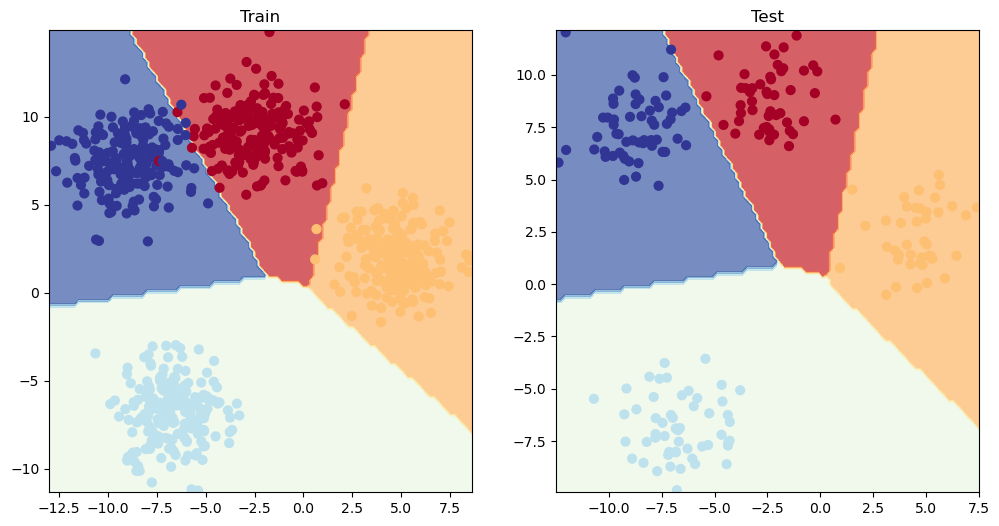

In [75]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)